In [34]:
import matplotlib.pyplot as plt
import stompy.model.delft.dflow_model as dfm
import stompy.model.hydro_model as hm
import xarray as xr
from stompy import utils
import pandas as pd
from stompy.plot import plot_wkb

import six

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib notebook

In [9]:
import sfb_csc

In [10]:
runs=[
    dict(run_dir="data_3d_2019_summer-v009",
         label="3D")
     ]

runs=pd.DataFrame(runs)

In [12]:
six.moves.reload_module(dfm)
six.moves.reload_module(sfb_csc)

runs['model'] = runs['run_dir'].apply(lambda r: sfb_csc.SfbCsc.load(r))

In [13]:
# Dev for stage comparisons
his_ds=runs.loc[0,'model'].his_dataset()


In [14]:
his_ds.stations # now 168 stations.

<xarray.DataArray 'stations' (stations: 168)>
array(['HS1', 'DOP', 'CCS', 'SG1', 'LN2', 'HAAS', 'SOI', 'SXS', 'RYI', 'HBW',
       'SSS', 'SUT', 'GES', 'DWS', 'LIB', 'LIS', 'FPX', 'SRV', 'LSHB', 'CCS1',
       'CCEH', 'BSPP', 'CCSC', 'WildlandsUpMarsh_stage', 'DLC', 'GSS', 'SDC',
       'SDI', 'TSL', 'CourtlandToe', 'LIY', 'ToeAtLiberty', 'HollandNBreach',
       'LibertyIslandCut', 'LibCutHolland', 'MIR', 'HST', 'DWSCTL', 'mdot_CC2',
       'mdot_LN1', 'mdot_CA3', 'mdot_HS1', 'mdot_BK1', 'mdot_CC1', 'mdot_BK2',
       'mdot_CAUL', 'mdot_UL1', 'mdot_CA1', 'mdot_HS2', 'P649', 'P2', 'P3',
       'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14',
       'P15', 'P16', 'P17', 'P18', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P29.5', 'P30', 'P31', 'P32', 'P33', 'P34',
       'P35', 'P36', 'ALA', 'RIC', 'BOL', 'CHI', 'ANH', 'MAL', 'BEN', 'MAR',
       'CAR', 'MIC', 'PSP', 'P241', 'GGB', 'PRE', 'M17', 'DB', 'SMB', 'DUM',
       'SOU', 'SAN', 'SHO', 'RIC1', 'CAR2', 'SUI', 'SFB1201', 'SFB1202',
       'SFB1203', 'SFB1204', 'SFB1205', 'SFB1206', 'SFB1207', 'SFB1208',
       'SFB1209', 'SFB1210', 'SFB1211', 'SFB1212', 'SFB1217', 'SFB1218',
       'SFB1219', 'SFB1220', 'SFB1221', 'SFB1222', 'SFB1223', 'SFB1224',
       'SFB1225', 'SFB1301', 'SFB1302', 'SFB1304', 'SFB1305', 'SFB1306',
       'SFB1307', 'SFB1308', 'SFB1309', 'SFB1310', 'SFB1311', 'SFB1312',
       'SFB1313', 'SFB1314', 'SFB1315', 'SFB1316', 'SFB1317', 'SFB1318',
       'SFB1319', 'SFB1320', 'SFB1322', 'SFB1323', 'SFB1324', 'SFB1325',
       'SFB1326', 'SFB1327', 'SFB1328', 'SFB1329', 'SFB1330', 'SFB1331',
       'SFB1332', 'SFEI_Coyote', 'USGS_ReserveFleet', 'USGS_ReserveFleet2',
       'USGS_GarnetSill', 'NOAA_PointReyes', 'NOAA_Richmond', 'NOAA_MareIslan',
       'Redwood'], dtype='<U22')
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
    station_name          (stations) |S256 b'HS1                             ...
  * stations              (stations) <U22 'HS1' 'DOP' ... 'Redwood'

In [7]:
# Define observations. Use the same classes as for BCs
# since they already have the relevant dynamic loading
#observations={
#    'SRV':dict(stage=hm.NwisStageBC(11455420,name='SRV'),
#               flow=hm.NwisFlowBC(11455420,name='SRV'))
#}

In [41]:
his

NameError: name 'his' is not defined

In [67]:
import stompy.model.data_comparison as dc

class ModelData: pass

class DFMStage(ModelData):
    station=None
    data_start=None # will be set from model
    data_stop =None
    
    def __init__(self,model,station):
        self.model=model
        self.station=station
        # Might transition this to better caching at some point.
        self.his=self.model.his_dataset()
        self.data_start=self.his.time.values[0]
        self.data_stop =self.his.time.values[-1]
        #self.data_start=self.model.run_start
        #self.data_stop =self.model.run_stop
        
    def src_data(self):
        da=self.his.sel(stations=self.station)['waterlevel']
        da=da.assign_coords(label='Pred')
        return da
    
    def plot_xy(self):
        return [self.his.station_x_coordinate.sel(stations=self.station).values,
                self.his.station_y_coordinate.sel(stations=self.station).values]
        
class PointCompare:
    name=None
    reference=0 # control metric calculation 
    predicted=1 # 
    
    def __init__(self,sources,**kw):
        self.sources=sources
        self.data=None
        utils.set_keywords(self,kw)
        
        if self.name is None:
            self.name=self.sources[0].name    
        
    def plot_xy(self):
        """
        return [x,y] for where this point[ish] comparison should be
        plotted.
        """
        for source in self.sources:
            try:
                xy=source.plot_xy()
                if xy is not None:
                    return xy
            except AttributeError:
                pass
        print("No sources provided a location")
        return [np.nan,np.nan]
        
    def assemble_data(self):
        if self.data is not None:
            return self.data
        
        # See which sources already have a date range.
        # choose the final date range based on those.
        starts=[]
        stops =[]
        for source in self.sources:
            if source.data_start is not None:
                starts.append(source.data_start)
            if source.data_stop is not None:
                stops.append(source.data_stop)
        # will need better logic than this. Maybe test for model vs obs.
        start=min(starts)
        stop =max(stops)
        print(f"Inferred time period: {start} to {stop}")
        
        self.data=[]
        
        labels={}
        for src_i,source in enumerate(self.sources):
            if source.data_start is None:
                source.data_start=start
            if source.data_stop is None:
                source.data_stop =stop
            da=source.src_data()
            if 'label' not in da.coords:
                if isinstance(source,hm.BC):
                    label="Obs"
                elif isinstance(source,ModelData):
                    label="Pred"
            else:
                label=da.label.item()
                
            if label in labels:
                label=label+str(src_i)
            labels[label]=True
            self.data.append(da.assign_coords(label=label))
        return self.data
    
    def calc_metrics(self):
        data=self.assemble_data() # list of dataarrays
        return dc.calc_metrics(data[self.reference],data[self.predicted],combine=True)

    def figure(self):
        self.assemble_data()
        self.combined=dc.combine_sources(self.data)
        fig=dc.calibration_figure_3panel(all_sources=self.data,
                                         combined=self.combined)
        fig.axes[0].legend(title=self.name,loc='upper left',bbox_to_anchor=(1,1),
                           frameon=0)
        fig.subplots_adjust(right=0.85,left=0.07,top=0.98,bottom=0.1)
        return fig

class StageCompare(PointCompare):
    pass

hm.NwisStageBC.cache_dir="cache"
hm.NOAAStageBC.cache_dir="cache"

# maybe a more generic way
comparisons=[
    StageCompare( [ hm.NwisStageBC(11455420,name='SRV') ]
                 + [DFMStage(model,'SRV') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    FlowCompare( [ hm.NwisStageBC(11455420,name='SRV') ]
                 + [DFMFlow(model,'RioVista') for model in runs['model']],
                 name="Rio Vista (SRV)"),
    

    StageCompare( [ hm.NwisStageBC(11447650,name='FPT') ]
                 + [DFMStage(model,'FPX') for model in runs['model']],
                 name="Freeport"),

    StageCompare( [ hm.NwisStageBC(11455385,name='RYI') ]
                 + [DFMStage(model,'RYI') for model in runs['model']],
                 name="RYI (near match)"),

    # Stage for 2020 to 2023. Has EC much earlier.
    #StageCompare( [ hm.NwisStageBC(11455280,name='HST') ]
    #             + [DFMStage(model,'HST') for model in runs['model']],
    #             name="HST"),

    # Hass near Elmira. Newly added observation point.
    #StageCompare( [ hm.NwisStageBC(11455278,name="HAS") ]
    #             + {DFMStage(model, 'HassElmira') for model in runs['model']],
    #               name="HAS"}
    
    # Newly added station
    StageCompare( [hm.NwisStageBC(11313433, name="DutchSlough")]
                 + [DFMStage(model, 'DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Newly added section
    FlowCompare( [hm.NwisFlowBC(11313433, name="DutchSlough")]
                 + [DFMFlow(model, 'DSL') for model in runs['model']],
                 name="Dutch Slough"),
    # Jersey Point 
    StageCompare( [hm.NwisStageBC(11337190, name="JerseyPoint")]
                 + [DFMStage(model, 'JPT') for model in runs['model']],
                 name="Dutch Slough"),
    FlowCompare( [hm.NwisStageBC(11337190, name="JerseyPoint")]
                 + [DFMFlow(model, 'JPT') for model in runs['model']],
                 name="Dutch Slough"),
    
    # Threemile Slough 
    StageCompare( [hm.NwisStageBC(11337080, name="ThreemileSlough")]
                 + [DFMStage(model, 'TSL') for model in runs['model']],
                 name="Dutch Slough"),
    FlowCompare( [hm.NwisStageBC(11337080, name="ThreemileSlough")]
                 + [DFMFlow(model, 'TSL') for model in runs['model']],
                 name="Dutch Slough"),
    
    # Delta Cross Channel
    StageCompare( [hm.NwisStageBC(11336600, name="DeltaCrossChannel")]
                 + [DFMStage(model, 'DLC') for model in runs['model']],
                 name="Dutch Slough"),
    FlowCompare( [hm.NwisStageBC(11336600, name="DeltaCrossChannel")]
                 + [DFMFlow(model, 'DLC') for model in runs['model']],
                 name="Dutch Slough"),
    
    # Sac below Georgiana
    StageCompare( [hm.NwisStageBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMStage(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    FlowCompare( [hm.NwisStageBC(11447905, name="SacBelowGeorgiana")]
                 + [DFMFlow(model, 'GES') for model in runs['model']],
                 name="Sac blw Georgiana"),
    
    # Georgiana Sl at Sac River
    StageCompare( [hm.NwisStageBC(11447903, name="Georgiana Sl")]
                 + [DFMStage(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    FlowCompare( [hm.NwisStageBC(11447903, name="Georgiana Sl")]
                 + [DFMFlow(model, 'GSS') for model in runs['model']],
                 name="Georgiana Sl"),
    
    # Sac above DCC
    StageCompare( [hm.NwisStageBC(11447890, name="Sac ab DCC")]
                 + [DFMStage(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    FlowCompare( [hm.NwisStageBC(11447890, name="Sac ab DCC")]
                 + [DFMFlow(model, 'SDC') for model in runs['model']],
                 name="Sac ab DCC"),
    
    # Prisoners Point
    StageCompare( [hm.NwisStageBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMStage(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),
    FlowCompare( [hm.NwisStageBC(11313460, name="SJ Prisoners Pt")]
                 + [DFMFlow(model, 'PRI') for model in runs['model']],
                 name="SJ Prisoners Pt"),

    # Garwood Bridge 
    StageCompare( [hm.NwisStageBC(11304810, name="SJ Garwood Br")]
                 + [DFMStage(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    FlowCompare( [hm.NwisStageBC(11304810, name="SJ Garwood Br")]
                 + [DFMFlow(model, 'GAR') for model in runs['model']],
                 name="SJ Garwood Br"),
    
    
    
    StageCompare( [hm.NwisStageBC(11455276,name="SHAG") ]
                 + [DFMStage(model,"SG1") for model runs['model']],
                 name="SHAG"),
    
    
    # ALA station is on land!
    StageCompare( [ hm.NOAAStageBC(station=9414750,name='Alameda') ]
                 + [DFMStage(model,'P23') for model in runs['model']],
                 name="Alameda (near)"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414290,name='San Francisco') ]
                 + [DFMStage(model,'PRE') for model in runs['model']],
                 name="San Francisco"),
    
    StageCompare( [ hm.NOAAStageBC(station=9414863,name='Richmond') ]
                 + [DFMStage(model,'NOAA_Richmond') for model in runs['model']],
                 name="Richmond"),

    StageCompare( [ hm.NOAAStageBC(station=9415144,name='Port Chicago') ]
                 + [DFMStage(model,'CHI') for model in runs['model']],
                 name="Port Chicago"),

    StageCompare( [ hm.NOAAStageBC(station=9415102,name='Martinez') ]
                 + [DFMStage(model,'MAR') for model in runs['model']],
                 name="Martinez"),

    StageCompare( [ hm.NOAAStageBC(station=9414523,name='Redwood City') ]
                 + [DFMStage(model,'Redwood') for model in runs['model']],
                 name="Redwood City"),
    
    
    # EC,Temp: USGS 11455508 van Sickle Island 2016-
    
    # EC, Temp, Stage, Flow: Dutch Slough 11313433
]

In [48]:
if 0:
    for comp in comparisons:
        comp.figure()

In [32]:
model=runs.model[0]
grid=model.grid
shore_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 298 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=4433425849.916859, 297 potential interiors


In [72]:
# dataframe with metrics, locations
recs=[]
for comp in comparisons:
    if not isinstance(comp,StageCompare): continue
    xy=comp.plot_xy()
    rec=dict(name=comp.name,x=xy[0],y=xy[1])
    # include the metrics
    rec.update(comp.calc_metrics()) 
    recs.append(rec)
comp_df=pd.DataFrame(recs)
comp_df

,name,x,y,bias,r,lag,lag_s,amp,wilmott,murphy,spearman_rho,spearman_p
0,Rio Vista (SRV),615117.0,4224383.0,0.386154,0.983581,-1 days +23:53:29.999998,-390.000002,0.728332,0.795318,0.201457,0.982349,0.0
1,Freeport,630728.0,4257433.0,30.977113,0.975490,-1 days +23:02:07.499975,-3472.500025,1.816870,0.034525,-2800.993435,0.957446,0.0
2,RYI (near match),616561.0,4230315.0,1.519009,0.980321,0 days 00:00:52.500000,52.500000,0.660017,0.398970,-8.789122,0.981347,0.0
3,Alameda (near),558453.0,4175881.0,0.010876,0.992172,-1 days +23:47:37.499995,-742.500005,0.829096,0.987273,0.957568,0.991572,0.0
4,San Francisco,547095.0,4184499.0,0.008539,0.981827,-1 days +23:35:59.999990,-1440.000010,0.850809,0.984286,0.946609,0.978596,0.0
5,Richmond,552647.926,4197938.639,0.039644,0.993104,-1 days +23:50:29.999996,-570.000004,0.850154,0.988807,0.961759,0.992257,0.0
6,Port Chicago,584340.697,4212589.985,0.105338,0.995321,-1 days +23:58:07.500000,-112.500000,0.881338,0.981413,0.933424,0.996221,0.0
7,Martinez,575527.0,4209246.0,0.055817,0.993553,-1 days +23:59:30,-30.000000,0.912494,0.991742,0.969778,0.996364,0.0
8,Redwood City,571096.635,4153824.755,0.021124,0.996733,-1 days +23:58:52.500000,-67.500000,0.905625,0.995721,0.984482,0.996921,0.0


<IPython.core.display.Javascript object>


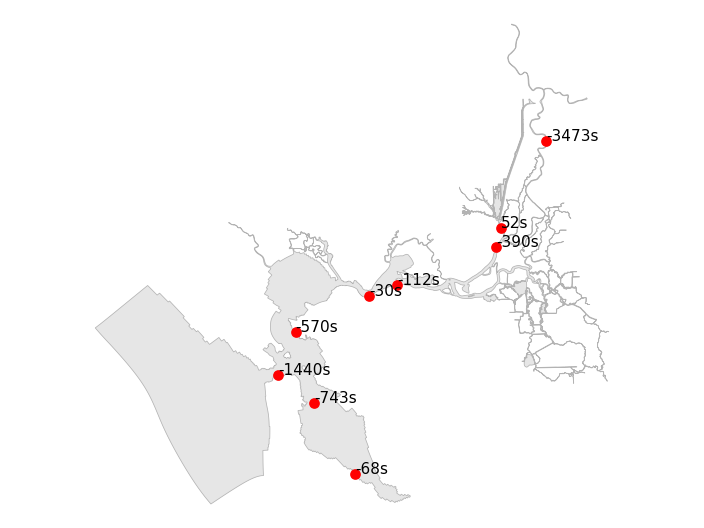

In [77]:
# Map showing stage calibration across the domain
def fig_stations(comp_df,hue=None,label='name',clim=None,fmt="%s"):
    fig,ax=plt.subplots()
    plot_wkb.plot_wkb(shore_poly,ax=ax,ec='0.7',lw=0.5,fc='0.9')
    fig.subplots_adjust(0,0,1,1)

    ax.axis('equal')
    ax.axis("off")

    for rec in comp_df.itertuples():
        ax.plot(rec.x,rec.y,'ro')
        if label:
            ax.text(rec.x,rec.y,fmt%getattr(rec,label))
    return fig

#fig_stations(comp_df) ;
#fig_stations(comp_df,label='amp',fmt="%.3f") ;
fig_stations(comp_df,label='lag_s',fmt="%.0fs") ;
